### Analyzing, visualizing and predicting local states in a localization problem
### Part-6: Predicting the limit of upper and lower whiskers
In the previous notebooks ([Part-3](https://github.com/helalme/UncertaintiesReductionInLocalization/blob/master/2.%20TrainingAndPredictionOfQ1.ipynb), [Part-4](https://github.com/helalme/UncertaintiesReductionInLocalization/blob/master/3.%20TrainingAndPredictionOfQ2.ipynb) and [Part-5](https://github.com/helalme/UncertaintiesReductionInLocalization/blob/master/4.%20TrainingAndPredictionOfQ3.ipynb)), we have accurately predicted the series of Q1, Q2 and Q3. In order to get the comprehensive idea about the local states of an SERVE, we will have to predict the lengths of upper and lower whiskers as well. Here we will show how to assesse the upper bounds and lower bounds whiskers.

#### Load necessary modules

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


#### From the [first notebook](https://github.com/helalme/UncertaintiesReductionInLocalization/blob/master/0.%20AnalyzeVisualize_LocalStatesDatasets.ipynb), we have seen that for each size of RVE the 50% of the local stress states (or IQR) are distributed withing a samller range, and thus rest 50% of local states have high scattering range. In such cases, the assessement of whiskers as $1.5\times IQR$ is a shear underestimation. Rather we can assume a suitable percentile upto which whiskers will be considered, and beyond whiskers, rest would be outliers. 

Any percnetiles from the 90th to 98th in the upperside, or, 2nd to 10th in the lower sides can be effetively predicted either by simple avering or by LSTM network. WE heve tried different percentiles from the both sides. So we can conveniently consider any percentiles as the limit of whiskers our prediction problem. Lets consider 5th percentiles and 90th percentiles as the lengths of whiskers in the lower and upper sides repectively, and predict. 

#### Load the training data i.e. the datasets of 5th percentiles

In [28]:
series = np.loadtxt('Data/5percentQuantile13to2000g.txt')
series

array([[-123.0524, -152.0952, -173.4156, -191.5646, -206.4036, -218.8984,
        -229.0958, -237.4958, -244.4062, -249.9146, -217.2708, -183.8341,
        -149.5208, -114.6071,  -79.3935,  -43.855 ,   -7.9498,   28.2617,
          64.6572,  101.095 ],
       [ -87.5675, -109.6188, -124.8356, -136.3709, -146.1513, -154.8813,
        -162.846 , -170.5562, -177.7021, -184.5153, -153.965 , -123.1325,
         -91.9846,  -60.7445,  -28.9278,    2.989 ,   35.3917,   68.207 ,
         101.1179,  134.5953],
       [ -95.3137, -116.3875, -128.825 , -138.1719, -145.5969, -151.8375,
        -157.2875, -162.2375, -166.95  , -171.6   , -139.275 , -107.0375,
         -74.9269,  -42.8225,  -10.7929,   21.2763,   53.5491,   85.8175,
         118.225 ,  150.8597],
       [ -74.6   ,  -94.8563, -107.821 , -117.737 , -125.912 , -132.938 ,
        -139.125 , -144.7   , -149.9   , -154.613 , -121.963 ,  -89.0525,
         -55.7188,  -22.3638,   11.0998,   44.7263,   78.44  ,  112.181 ,
         145.9   , 

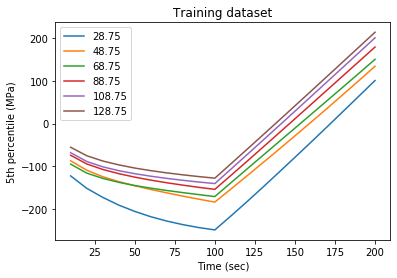

In [16]:
time=range(10,201,10)
plt.plot(time, series[0],  label='28.75')
plt.plot(time, series[1],  label='48.75')
plt.plot(time, series[2],  label='68.75')
plt.plot(time, series[3],  label='88.75')
plt.plot(time, series[4],  label='108.75')
plt.plot(time, series[5],  label='128.75')

plt.xlabel('Time (sec)')
plt.ylabel('5th percentile (MPa)')
plt.title('Training dataset')
plt.legend()

plt.show()

### Like previous notebooks, preprocess the training data

In [29]:
slope1=(series[0][10]-series[0][9])/10.0
slope2=(series[1][10]-series[1][9])/10.0
slope3=(series[2][10]-series[2][9])/10.0
slope4=(series[3][10]-series[3][9])/10.0
slope5=(series[4][10]-series[4][9])/10.0
slope6=(series[5][10]-series[5][9])/10.0

print(slope1, slope2, slope3, slope4, slope5,slope6)
print((slope1+slope2+slope3+slope4+slope5+slope6)/6)

3.26438 3.0550299999999995 3.232499999999999 3.2650000000000006 3.3762000000000016 3.3633399999999996
3.2594083333333335


In [30]:
slope=3.35 # take an approximate for all curves
for i in range(0,6):
    for j in range(10,20):
        series[i][j]=series[i][j-1]+slope*10

        

In [31]:
#second series ke ektu more sequencial korar chesta
series[1]=series[1]-12

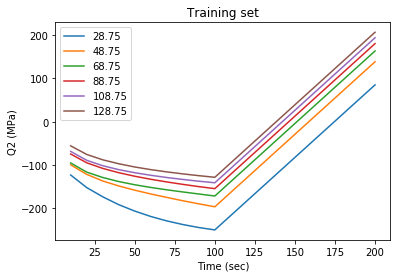

In [32]:
time=range(10,201,10)
plt.plot(time, series[0],  label='28.75')
plt.plot(time, series[1],  label='48.75')
plt.plot(time, series[2],  label='68.75')
plt.plot(time, series[3],  label='88.75')
plt.plot(time, series[4],  label='108.75')
plt.plot(time, series[5],  label='128.75')

plt.xlabel('Time (sec)')
plt.ylabel('Q2 (MPa)')
plt.title('Training set')
plt.legend()

plt.show()

#### Arrange the training data

In [33]:
Xtrain1=np.array([[series[0],series[1]],[series[1],series[2]],[series[2],series[3]],[series[3],series[4]]])
Ytrain1 = np.array([series[2],series[3],series[4],series[5]]) 


#### Training the network

In [39]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.12  ): #and logs.get('val_loss')<1
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,activation='relu', return_sequences=True, input_shape=(2, 20))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),  
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain1, Ytrain1, epochs=1000, callbacks=[callbacks]) #, validation_data=(Xtest, Ytest)

Train on 4 samples
Epoch 1/1000
4/4 [==============================] - 3s 770ms/sample - loss: 16465.4707
Epoch 2/1000
4/4 [==============================] - 0s 0s/sample - loss: 13399.4609
Epoch 3/1000
4/4 [==============================] - 0s 2ms/sample - loss: 9801.6523
Epoch 4/1000
4/4 [==============================] - 0s 3ms/sample - loss: 5805.2559
Epoch 5/1000
4/4 [==============================] - 0s 2ms/sample - loss: 4672.1982
Epoch 6/1000
4/4 [==============================] - 0s 2ms/sample - loss: 3183.0923
Epoch 7/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1756.6748
Epoch 8/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1100.5511
Epoch 9/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1265.6483
Epoch 10/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1292.2886
Epoch 11/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1030.2990
Epoch 12/1000
4/4 [==============================] -

Epoch 99/1000
4/4 [==============================] - 0s 3ms/sample - loss: 93.9997
Epoch 100/1000
4/4 [==============================] - 0s 2ms/sample - loss: 93.4961
Epoch 101/1000
4/4 [==============================] - 0s 2ms/sample - loss: 93.3635
Epoch 102/1000
4/4 [==============================] - 0s 2ms/sample - loss: 93.4353
Epoch 103/1000
4/4 [==============================] - 0s 3ms/sample - loss: 88.5415
Epoch 104/1000
4/4 [==============================] - 0s 2ms/sample - loss: 86.1521
Epoch 105/1000
4/4 [==============================] - 0s 3ms/sample - loss: 87.6840
Epoch 106/1000
4/4 [==============================] - 0s 3ms/sample - loss: 87.6008
Epoch 107/1000
4/4 [==============================] - 0s 2ms/sample - loss: 88.2959
Epoch 108/1000
4/4 [==============================] - 0s 3ms/sample - loss: 88.5127
Epoch 109/1000
4/4 [==============================] - 0s 2ms/sample - loss: 86.3009
Epoch 110/1000
4/4 [==============================] - 0s 2ms/sample - loss: 8

Epoch 197/1000
4/4 [==============================] - 0s 2ms/sample - loss: 40.7381
Epoch 198/1000
4/4 [==============================] - 0s 3ms/sample - loss: 39.5309
Epoch 199/1000
4/4 [==============================] - 0s 3ms/sample - loss: 38.3271
Epoch 200/1000
4/4 [==============================] - 0s 2ms/sample - loss: 37.1319
Epoch 201/1000
4/4 [==============================] - 0s 3ms/sample - loss: 35.9575
Epoch 202/1000
4/4 [==============================] - 0s 2ms/sample - loss: 34.7947
Epoch 203/1000
4/4 [==============================] - 0s 2ms/sample - loss: 33.6444
Epoch 204/1000
4/4 [==============================] - 0s 3ms/sample - loss: 32.5117
Epoch 205/1000
4/4 [==============================] - 0s 2ms/sample - loss: 31.4490
Epoch 206/1000
4/4 [==============================] - 0s 2ms/sample - loss: 30.3608
Epoch 207/1000
4/4 [==============================] - 0s 3ms/sample - loss: 29.2936
Epoch 208/1000
4/4 [==============================] - 0s 2ms/sample - loss: 

Epoch 296/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.7963
Epoch 297/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1.7477
Epoch 298/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.7074
Epoch 299/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.6625
Epoch 300/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.6289
Epoch 301/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.5831
Epoch 302/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1.5510
Epoch 303/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.5091
Epoch 304/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.4757
Epoch 305/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1.4424
Epoch 306/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1.4088
Epoch 307/1000
4/4 [==============================] - 0s 2ms/sample - loss: 1.3805
Epoc

Epoch 395/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3838
Epoch 396/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.3797
Epoch 397/1000
4/4 [==============================] - 0s 1ms/sample - loss: 0.3759
Epoch 398/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3730
Epoch 399/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3689
Epoch 400/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3658
Epoch 401/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.3630
Epoch 402/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.3590
Epoch 403/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3567
Epoch 404/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.3547
Epoch 405/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.3498
Epoch 406/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.3473
Epoc

Epoch 494/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.1864
Epoch 495/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1854
Epoch 496/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1844
Epoch 497/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.1832
Epoch 498/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.1821
Epoch 499/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1811
Epoch 500/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1801
Epoch 501/1000
4/4 [==============================] - 0s 2ms/sample - loss: 0.1790
Epoch 502/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1780
Epoch 503/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1770
Epoch 504/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1761
Epoch 505/1000
4/4 [==============================] - 0s 3ms/sample - loss: 0.1751
Epoc

#### Predict the 7th set

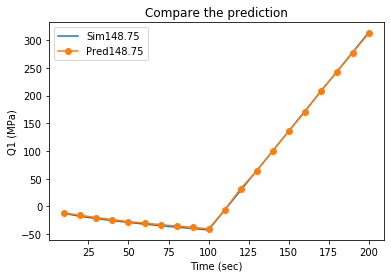

In [40]:
x5=np.array([[series[4],series[5]]])
y5=model.predict(x5)

time=range(10,201,10)

#plt.plot(time, series[2],  label='68.75')
#plt.plot(time, series[3],  label='88.75')
#plt.plot(time, series[4],  label='108.75')
#plt.plot(time, series[5],  label='128.75')
plt.plot(time, series[6],  label='Sim148.75')
plt.plot(time, y5[0], 'o-', label='Pred148.75')

plt.xlabel('Time (sec)')
plt.ylabel('Q1 (MPa)')
plt.title('Compare the prediction')
plt.legend()

plt.show()

#### The prediction shows very good results. See the losses curve

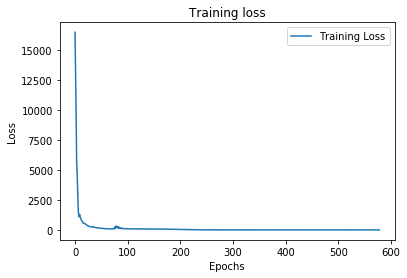

In [42]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs[0:], loss[0:],  label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

plt.show()

#### Lets continue the training for the prediction of 8th set

In [44]:
Xtrain2=np.array([[series[0],series[1]],[series[1],series[2]],[series[2],series[3]],[series[3],series[4]],[series[4],series[5]]])
Ytrain2 = np.array([series[2],series[3],series[4],series[5],y5[0]])

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.12   ): #and logs.get('val_loss')<1
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,activation='relu', return_sequences=True, input_shape=(2, 20))),#
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),  #
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain2, Ytrain2, epochs=1000, callbacks=[callbacks]) #, validation_data=(Xtest, Ytest)



Train on 5 samples
Epoch 1/1000
5/5 [==============================] - 3s 637ms/sample - loss: 14760.5996
Epoch 2/1000
5/5 [==============================] - 0s 3ms/sample - loss: 12726.8545
Epoch 3/1000
5/5 [==============================] - 0s 3ms/sample - loss: 8964.4609
Epoch 4/1000
5/5 [==============================] - 0s 3ms/sample - loss: 7347.4795
Epoch 5/1000
5/5 [==============================] - 0s 2ms/sample - loss: 5060.1807
Epoch 6/1000
5/5 [==============================] - 0s 2ms/sample - loss: 3473.7075
Epoch 7/1000
5/5 [==============================] - 0s 1ms/sample - loss: 2393.7551
Epoch 8/1000
5/5 [==============================] - 0s 1ms/sample - loss: 1560.7795
Epoch 9/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1033.7620
Epoch 10/1000
5/5 [==============================] - 0s 2ms/sample - loss: 807.3802
Epoch 11/1000
5/5 [==============================] - 0s 1ms/sample - loss: 643.7906
Epoch 12/1000
5/5 [==============================] - 

Epoch 100/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.3888
Epoch 101/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.3311
Epoch 102/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.2719
Epoch 103/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.2416
Epoch 104/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.1657
Epoch 105/1000
5/5 [==============================] - 0s 3ms/sample - loss: 1.1336
Epoch 106/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.0806
Epoch 107/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.0489
Epoch 108/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.0226
Epoch 109/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.9785
Epoch 110/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.9518
Epoch 111/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.9002
Epoc

Epoch 199/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4869
Epoch 200/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4862
Epoch 201/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4855
Epoch 202/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4848
Epoch 203/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4842
Epoch 204/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4835
Epoch 205/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4829
Epoch 206/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4823
Epoch 207/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4817
Epoch 208/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4810
Epoch 209/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4805
Epoch 210/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4799
Epoc

Epoch 298/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4485
Epoch 299/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4482
Epoch 300/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4479
Epoch 301/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4476
Epoch 302/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4473
Epoch 303/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4471
Epoch 304/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4468
Epoch 305/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4465
Epoch 306/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4462
Epoch 307/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4459
Epoch 308/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4456
Epoch 309/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4453
Epoc

Epoch 397/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4202
Epoch 398/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4199
Epoch 399/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4196
Epoch 400/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4193
Epoch 401/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.4190
Epoch 402/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4188
Epoch 403/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4185
Epoch 404/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4182
Epoch 405/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4179
Epoch 406/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4177
Epoch 407/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4174
Epoch 408/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.4171
Epoc

Epoch 496/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3940
Epoch 497/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3938
Epoch 498/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3935
Epoch 499/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3933
Epoch 500/1000
5/5 [==============================] - 0s 3ms/sample - loss: 0.3930
Epoch 501/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3928
Epoch 502/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3925
Epoch 503/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3923
Epoch 504/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3920
Epoch 505/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3918
Epoch 506/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3915
Epoch 507/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3913
Epoc

Epoch 595/1000
5/5 [==============================] - 0s 2ms/sample - loss: 113.0907
Epoch 596/1000
5/5 [==============================] - 0s 2ms/sample - loss: 43.6691
Epoch 597/1000
5/5 [==============================] - 0s 2ms/sample - loss: 2.4761
Epoch 598/1000
5/5 [==============================] - 0s 2ms/sample - loss: 50.7850
Epoch 599/1000
5/5 [==============================] - 0s 2ms/sample - loss: 75.0890
Epoch 600/1000
5/5 [==============================] - 0s 2ms/sample - loss: 7.7026
Epoch 601/1000
5/5 [==============================] - 0s 2ms/sample - loss: 24.6912
Epoch 602/1000
5/5 [==============================] - 0s 2ms/sample - loss: 60.6052
Epoch 603/1000
5/5 [==============================] - 0s 2ms/sample - loss: 6.6268
Epoch 604/1000
5/5 [==============================] - 0s 2ms/sample - loss: 23.5539
Epoch 605/1000
5/5 [==============================] - 0s 2ms/sample - loss: 43.6872
Epoch 606/1000
5/5 [==============================] - 0s 2ms/sample - loss: 1.

Epoch 694/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3724
Epoch 695/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3746
Epoch 696/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3723
Epoch 697/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3717
Epoch 698/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3731
Epoch 699/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3700
Epoch 700/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3715
Epoch 701/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3708
Epoch 702/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3693
Epoch 703/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3707
Epoch 704/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3688
Epoch 705/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3690
Epoc

Epoch 793/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3496
Epoch 794/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3494
Epoch 795/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3492
Epoch 796/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3490
Epoch 797/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3488
Epoch 798/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3486
Epoch 799/1000
5/5 [==============================] - 0s 613us/sample - loss: 0.3484
Epoch 800/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3482
Epoch 801/1000
5/5 [==============================] - 0s 3ms/sample - loss: 0.3480
Epoch 802/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3478
Epoch 803/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3476
Epoch 804/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3474
Ep

Epoch 892/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3312
Epoch 893/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3310
Epoch 894/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3308
Epoch 895/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3307
Epoch 896/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3305
Epoch 897/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3303
Epoch 898/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3301
Epoch 899/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3300
Epoch 900/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3298
Epoch 901/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3296
Epoch 902/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3294
Epoch 903/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3293
Epoc

Epoch 991/1000
5/5 [==============================] - 0s 1ms/sample - loss: 0.3149
Epoch 992/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3148
Epoch 993/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3146
Epoch 994/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3145
Epoch 995/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3143
Epoch 996/1000
5/5 [==============================] - 0s 4ms/sample - loss: 0.3142
Epoch 997/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3140
Epoch 998/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3138
Epoch 999/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3137
Epoch 1000/1000
5/5 [==============================] - 0s 2ms/sample - loss: 0.3135


#### Compare the prediction of 8th set

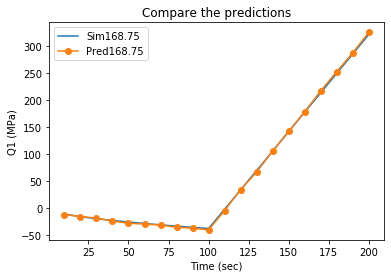

In [45]:
x6=np.array([[series[5],y5[0]]])
y6=model.predict(x6)

time=range(10,201,10)

#plt.plot(time, series[6],  label='Sim148.75')  
plt.plot(time, series[7],  label='Sim168.75')
#plt.plot(time, y5[0], 'o-', label='Pred148.75')
plt.plot(time, y6[0], 'o-', label='Pred168.75')
plt.xlabel('Time (sec)')
plt.ylabel('Q1 (MPa)')
plt.title('Compare the predictions')
plt.legend()

plt.show()

#### So it is clear that the simialr LSTM network with a specific architecture can prediction the curve of any percnetiles e.g. 5th, 10th, 25th, 50th, 75th, 90th, 95th etc.

====================================================================================================

#### We have seen the prediction of whiskers in the lower side. We need it in the upper side as well, lets consider the 90th percentiles is the limit of upper whiskers.

### To visualize the 90th percentiles, we need to load all the local states for each RVE

In [35]:
data1=pd.read_csv('Data/S33-13g-20timestepsData.txt', delimiter="  ", header=None )
data2=pd.read_csv('Data/S33-50g-20timestepsData.txt', delimiter="  ", header=None )
data3=pd.read_csv('Data/S33-150g-20timestepsData.txt', delimiter="  ", header=None )
data4=pd.read_csv('Data/S33-300g-20timestepsData.txt', delimiter="  ", header=None )
data5=pd.read_csv('Data/S33-550g-20timestepsData.txt', delimiter="  ", header=None )
data6=pd.read_csv('Data/S33-900g-20timestepsData.txt', delimiter="  ", header=None )
data7=pd.read_csv('Data/S33-1400g-20timestepsData.txt', delimiter="  ", header=None )
data8=pd.read_csv('Data/S33-2000g-20timestepsData.txt', delimiter="  ", header=None )

C:\Users\chow_he\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\chow_he\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\chow_he\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you ca

#### Visualization of 90th percentiles of 6 datasets

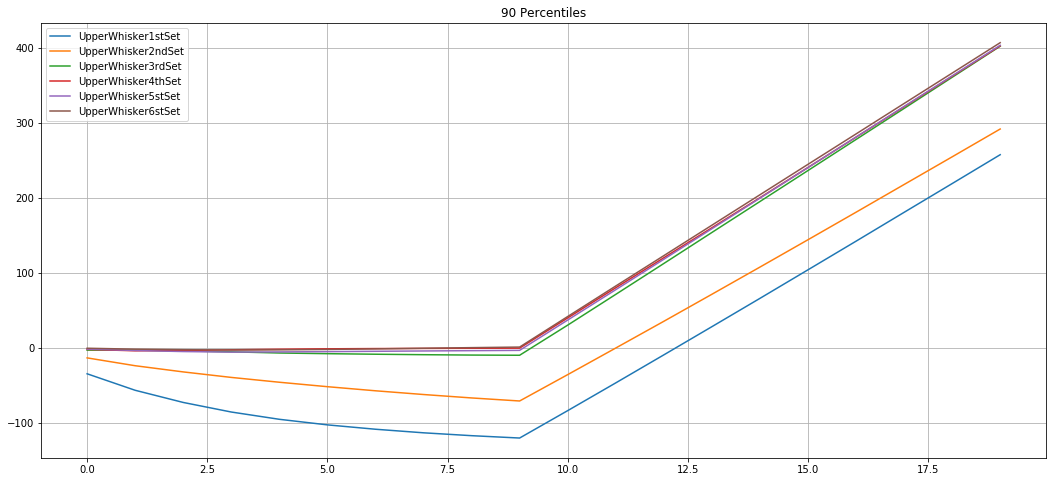

In [36]:
plt.figure(figsize=(18,8))

plt.plot(data1.quantile(q=.9),  label='UpperWhisker1stSet')
plt.plot(data2.quantile(q=.9),  label='UpperWhisker2ndSet')
plt.plot(data3.quantile(q=.9),  label='UpperWhisker3rdSet')
plt.plot(data4.quantile(q=.9),  label='UpperWhisker4thSet')
plt.plot(data5.quantile(q=.9),  label='UpperWhisker5stSet')
plt.plot(data6.quantile(q=.9),  label='UpperWhisker6stSet')

plt.title('90 Percentiles')
plt.grid()
plt.legend()
plt.show()

#### From the above plot, it is clear that the series of 90th percentiles for larger RVE size are very close. So we do not need to use a neural netowork here, rather a simple average would be fine for the prediction of 7th and 8th set. Lets take an average of 3rd to 6th sets, and compare with the same percentiles of the 7th and 8th sets.

In [37]:
q90_avg=(data3.quantile(q=.9)+data4.quantile(q=.9)+data5.quantile(q=.9)+data6.quantile(q=.9))/4.0

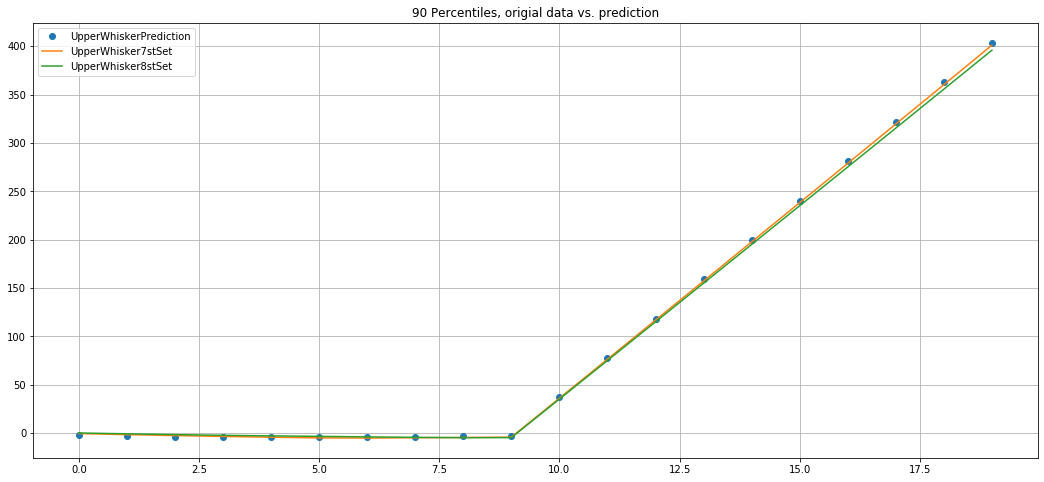

In [39]:
plt.figure(figsize=(18,8))

plt.plot(q90_avg, 'o', label='UpperWhiskerPrediction')
plt.plot(data7.quantile(q=.9),  label='UpperWhisker7stSet')
plt.plot(data8.quantile(q=.9),  label='UpperWhisker8stSet')

plt.title('90 Percentiles, origial data vs. prediction')
plt.grid()
plt.legend()
plt.show()

### It seems that the series of 90th percentile of the local states is very straight forward and easy to assesse. The summary is that, like Q1 to Q3, the lower and the upper whiskers can be predicted with 6 training sets of data. 